In [83]:
BASELINE = False

import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import faiss
import pickle
import cv2 as cv
import numpy as np
from tensorflow import keras

import logging
from telegram.ext import Updater
from telegram.ext import CommandHandler
from telegram.ext import MessageHandler, Filters

logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO)
logger = logging.getLogger(__name__)

updater = Updater(token='1905062828:AAEVNf9oEDaWjSqYrLbZOVBPhE-ttQqGK4w',
                  use_context=True)
dispatcher = updater.dispatcher

release_info = pickle.load(open('../release_info.p', 'rb'))
if not BASELINE:
    embedding = keras.models.load_model('../embedding_model')
    embedding_vectors = pickle.load(open('../embedding_vectors.p', 'rb'))
else:
    embedding = keras.models.load_model('../image_model')
    embedding_vectors = pickle.load(open('../image_vectors.p', 'rb'))

index_to_release = dict(enumerate(embedding_vectors))
vectors = np.array([embedding_vectors[_] for _ in embedding_vectors],
                   dtype=np.float32)
if not BASELINE:
    index = faiss.IndexFlatIP(vectors.shape[1])
    faiss.normalize_L2(vectors)
else:
    index = faiss.IndexFlatL2(vectors.shape[1])
index.add(vectors)

IMG_SIZE = 224  #######


def preprocess_image(image):
    img = cv.resize(image, (IMG_SIZE, IMG_SIZE), interpolation=cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img


def predict(image, topk=1):
    x = embedding.predict(np.array([preprocess_image(image)]))
    if not BASELINE:
        x = x / np.linalg.norm(x[0])
    y = index.search(x, topk)
    return [float(_) for _ in y[0][0][:topk]
            ], [index_to_release[_] for _ in y[1][0][:topk]]


2021-07-29 14:35:25,733 - tensorflow - WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-07-29 14:35:26,509 - absl - WARNING - Importing a function (__inference_top_activation_layer_call_and_return_conditional_losses_25839) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:26,620 - absl - WARNING - Importing a function (__inference_block4a_activation_layer_call_and_return_conditional_losses_37139) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:26,666 - absl - WARNING - Importing a function (__inference_stem_activation_layer_call_and_return_conditional_losses_35368) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14

2021-07-29 14:35:28,050 - absl - WARNING - Importing a function (__inference_block2a_se_reduce_layer_call_and_return_conditional_losses_35805) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:28,056 - absl - WARNING - Importing a function (__inference_block3a_se_reduce_layer_call_and_return_conditional_losses_21889) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:28,066 - absl - WARNING - Importing a function (__inference_block5a_se_reduce_layer_call_and_return_conditional_losses_38233) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:28,098 - absl - WARNING - Importing a function (__inference_block3a_activation_layer_call_and_return_conditional_losses_36452) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:28,132 - absl - WARNING - Importing a function (__inference_block6a_expand_activation_layer_call_and_r

2021-07-29 14:35:29,520 - absl - WARNING - Importing a function (__inference_block4a_se_reduce_layer_call_and_return_conditional_losses_37179) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:29,530 - absl - WARNING - Importing a function (__inference_block4b_expand_activation_layer_call_and_return_conditional_losses_22677) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:29,543 - absl - WARNING - Importing a function (__inference_block3a_expand_activation_layer_call_and_return_conditional_losses_21785) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:29,550 - absl - WARNING - Importing a function (__inference_block5c_activation_layer_call_and_return_conditional_losses_38880) with ops with custom gradients. Will likely fail if a gradient is requested.
2021-07-29 14:35:29,570 - absl - WARNING - Importing a function (__inference_block5a_activation_layer_c

2021-07-29 14:35:33,004 - tensorflow - WARNING - No training configuration found in save file, so the model was *not* compiled. Compile it manually.


In [128]:
proximities = np.zeros((len(embedding_vectors), ))
video = cv.VideoCapture('video.mp4')
while True:
    for skip in range(5):
        flag, frame = video.read()
    if not flag:
        break
    if frame.shape[0] > frame.shape[1]:
        frame = frame[(frame.shape[0] - frame.shape[1]) //
                      2:(frame.shape[0] + frame.shape[1]) // 2, :, :]
    else:
        frame = frame[:, (frame.shape[1] - frame.shape[0]) //
                      2:(frame.shape[1] + frame.shape[0]) // 2, :]
    frame = cv.resize(frame, (IMG_SIZE, IMG_SIZE),
                      interpolation=cv.INTER_AREA)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    x = embedding.predict(np.array([frame]))
    if not BASELINE:
        x = x / np.linalg.norm(x[0])
    y = index.search(x, 10)  # only consider top 10
    for _ in range(len(y[0][0])):
        proximities[y[1][0][_]] += y[0][0][_]
id = index_to_release[np.argmax(proximities)]
artist = release_info[str(id)][0]
title = release_info[str(id)][1]
url = release_info[str(id)][2]

In [129]:
from IPython.core.display import HTML, display

In [130]:
artist, title, url

('Machete (8) & Trujillo',
 'Miramar EP',
 'https://img.discogs.com/4WJY6yNmyIst4Fm49p0dflDWC3k=/fit-in/150x150/filters:strip_icc():format(jpeg):mode_rgb():quality(40)/discogs-images/R-15436103-1591489103-2973.jpeg.jpg')

In [131]:
display(HTML(f'<img src={url}>'))

In [187]:
video = cv.VideoCapture('video.mp4')

In [193]:
flag, frame = video.read()
#frame = cv.imread('../popsike/cropped_1652073.jpg', cv.IMREAD_COLOR)

In [194]:
if frame.shape[0] > frame.shape[1]:
    frame = frame[(frame.shape[0] - frame.shape[1]) //
                  2:(frame.shape[0] + frame.shape[1]) // 2, :, :]
else:
    frame = frame[:, (frame.shape[1] - frame.shape[0]) //
                  2:(frame.shape[1] + frame.shape[0]) // 2, :]
frame = cv.resize(frame, (IMG_SIZE, IMG_SIZE),
                  interpolation=cv.INTER_AREA)
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

In [195]:
frame.shape

(224, 224, 3)

In [196]:
from matplotlib import pyplot as plt

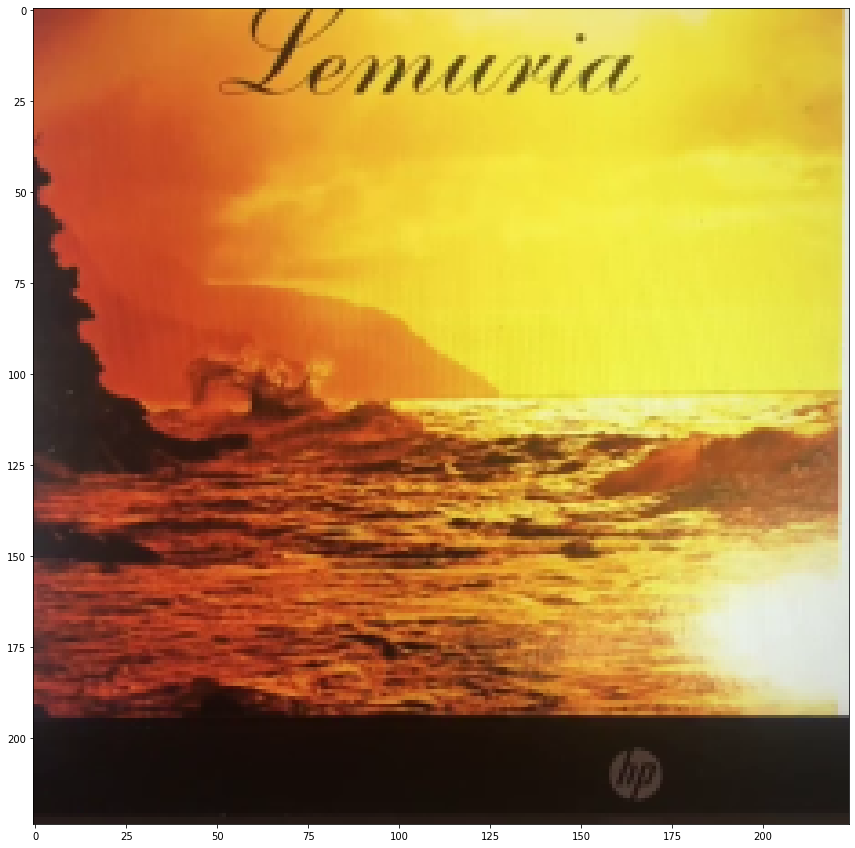

In [197]:
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(frame)
plt.show()

In [198]:
x = embedding.predict(np.array([frame]))

In [199]:
np.dot(x, embedding_vectors['1652073'])/np.linalg.norm(x)/np.linalg.norm(embedding_vectors['1652073'])

array([0.7721921], dtype=float32)

In [200]:
x = x/np.linalg.norm(x)
y = index.search(x, 20)

In [201]:
y[0][0]

array([0.80258423, 0.78844196, 0.78125274, 0.77436846, 0.77360743,
       0.7721922 , 0.7666156 , 0.763147  , 0.76278096, 0.7622299 ,
       0.76159257, 0.7609102 , 0.75967824, 0.7592323 , 0.75053954,
       0.75028193, 0.7488687 , 0.74808025, 0.7473544 , 0.74672216],
      dtype=float32)

In [202]:
for _ in y[1][0]:
    display(HTML(f'<img src={release_info[str(index_to_release[_])][2]}>'))